# 1 parameter bayesian linear regression
## prior -> Normal distribution

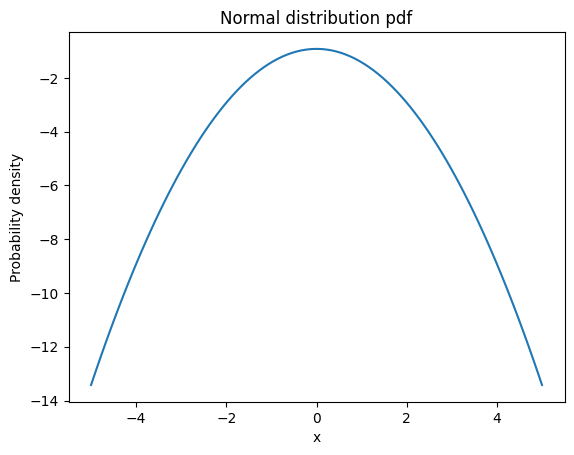

In [37]:
import torch
import matplotlib.pyplot as plt

prior_mean = 0
prior_std = 1

prior_dist = torch.distributions.Normal(prior_mean, prior_std)

def plot_normal_distribution(dist, x=None):
    if x is None:
        x = torch.linspace(-5, 5, 100)
    y = dist.log_prob(x)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('Probability density')
    plt.title('Normal distribution pdf')

plot_normal_distribution(prior_dist)
plt.show()

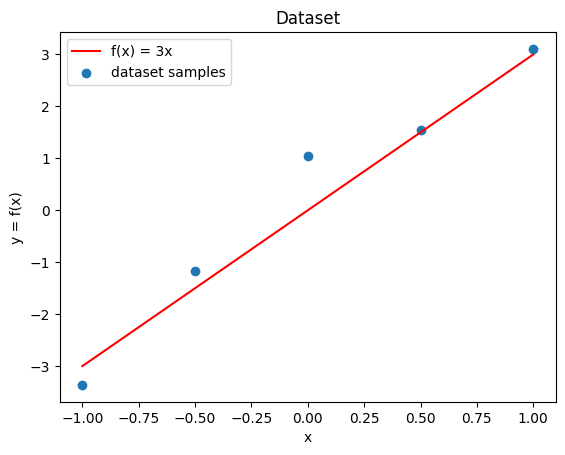

In [38]:
# dataset

sigma = 0.5

def f(x):
    return 3 * x

def generate_dataset(n):
    noise = torch.distributions.Normal(0, sigma).sample((n,))
    x = torch.linspace(-1, 1, n)
    y = f(x) + noise
    return x, y

# Plot dataset
x, y = generate_dataset(5)
plt.plot(x,f(x), color='red', label='f(x) = 3x')
plt.scatter(x, y, label='dataset samples')
plt.legend()
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.title('Dataset')
plt.show()


In [39]:
# likelihood

def forward(x, theta):
    return x*theta

def log_likelihood(theta):
    mu = forward(x, theta)
    sigma = torch.tensor(0.5)
    dist = torch.distributions.Normal(mu, sigma)
    return dist.log_prob(y).sum()

log_likelihood(2.5)

tensor(-5.7059)

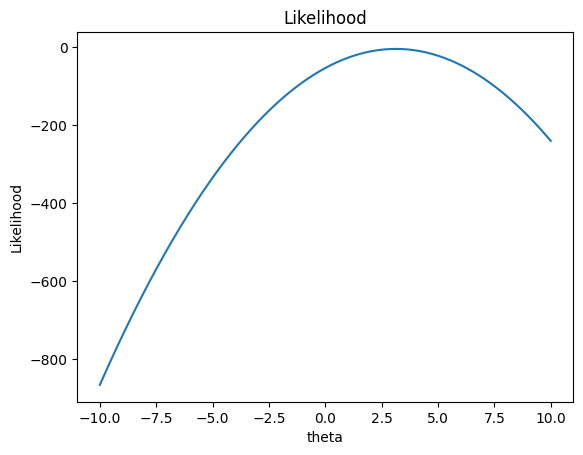

In [40]:
# Plot likelihood

thetas = torch.linspace(-10, 10, 1000)
likelihoods = [log_likelihood(theta) for theta in thetas]
plt.plot(thetas, likelihoods)
plt.xlabel('theta')
plt.ylabel('Likelihood')
plt.title('Likelihood')
plt.show()

In [41]:
# Calculate theta mle

def mle():
    theta_mle = torch.tensor(0.0, requires_grad=True)
    optimizer = torch.optim.Adam([theta_mle], lr=0.1)
    for i in range(1000):
        optimizer.zero_grad()
        loss = -log_likelihood(theta_mle)
        loss.backward()
        optimizer.step()
    return theta_mle

theta_mle = mle()
print('theta_mle:', theta_mle)


theta_mle: tensor(3.1307, requires_grad=True)


In [42]:
# theta mle using closed form solution

import numpy as np

# Assuming X and y are your input features and target values
X_design = np.column_stack((np.ones_like(x), x))

# Calculate the coefficients using the closed-form solution
theta_mle = np.linalg.inv(X_design.T @ X_design) @ X_design.T @ np.array(y)
theta_mle

array([0.23245975, 3.1307285 ], dtype=float32)

In [43]:
# # Plot theta mle, prior mean and prior, likelihood

# plot_normal_distribution(prior_dist, x=torch.linspace(-10, 10, 1000))
# plt.axvline(theta_mle, color='red', label='theta_mle', linestyle='--')
# plt.axvline(prior_mean, color='green', label='prior mean', linestyle='--')
# plt.plot(thetas, likelihoods, label='likelihood', color='orange')
# plt.legend()
# plt.show()

In [44]:
# Define log posterior

def log_posterior(theta):
    return log_likelihood(theta) + prior_dist.log_prob(theta)

In [45]:
# Calculate theta map

def map():
    theta_map = torch.tensor(0.0, requires_grad=True)
    optimizer = torch.optim.Adam([theta_map], lr=0.1)
    for i in range(1000):
        optimizer.zero_grad()
        loss = -log_posterior(theta_map)
        loss.backward()
        optimizer.step()
    return theta_map

theta_map = map()
print('theta_map:', theta_map)

theta_map: tensor(2.8461, requires_grad=True)


In [46]:
# theta map using closed form solution

import numpy as np

# Assuming X and y are your input features and target values
X_design = np.column_stack((np.ones_like(x), x))

# Calculate the coefficients using the closed-form solution
theta_map = np.linalg.inv(X_design.T @ X_design + (sigma/prior_std)**2) @ X_design.T @ np.array(y)
theta_map

array([0.0862342, 2.838277 ], dtype=float32)

In [47]:
# Plot theta mle, prior mean and prior, likelihood

# plot_normal_distribution(prior_dist, x=torch.linspace(-10, 10, 1000))
# plt.axvline(theta_mle.detach().numpy(), color='red', label='theta_mle', linestyle='--')
# plt.axvline(prior_mean, color='green', label='prior mean', linestyle='--')
# plt.axvline(theta_map.detach().numpy(), color='purple', label='theta_map', linestyle='--')
# plt.plot(thetas, likelihoods, label='likelihood', color='orange')
# plt.legend()
# plt.show()

In [50]:
x

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])

[[1.05 1.  ]
 [1.   1.1 ]]
[36.18894  39.087208]


TypeError: Input z must be 2D, not 1D

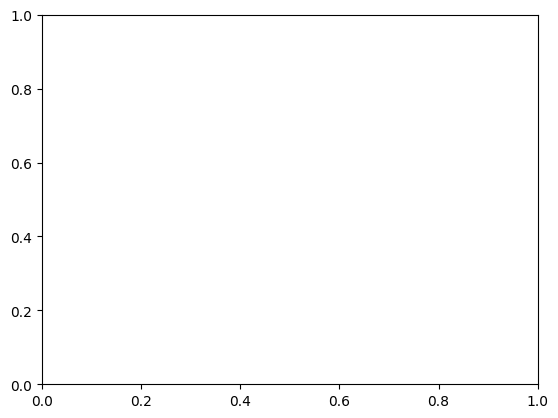

In [51]:
# Calculate theta posterior using closed form solution

import numpy as np

# Assuming X and y are your input features and target values
X = x
X = np.column_stack((np.ones_like(x), x))
sigma_posterior = np.linalg.inv((X.T @ X) / ((sigma)**2)) + (1/prior_std)
print(sigma_posterior)
mean_posterior = sigma_posterior @ ((X.T @ np.array(y)) / ((sigma)**2) + (prior_mean/prior_std))
print(mean_posterior)
theta_posterior = torch.distributions.MultivariateNormal(torch.tensor(mean_posterior), torch.tensor(sigma_posterior))

# Plot the posterior

fig = plt.figure()
plt.contourf(thetas, thetas, theta_posterior.log_prob(torch.stack((thetas, thetas), dim=1)).exp().numpy())
plt.show()


# plt.legend()
# plt.show() 

# 2 parameter bayesian linear regression
## prior -> Normal distribution

In [197]:
import torch
import matplotlib.pyplot as plt

prior_mean = torch.tensor([0.0, 0.0])
prior_cov = torch.tensor([[1.,-0.2],[-0.2,1.]])
b = 1

def multivariate_normal(prior_mean, prior_cov):
    return torch.distributions.MultivariateNormal(prior_mean, prior_cov)
prior_dist = multivariate_normal(prior_mean, prior_cov)

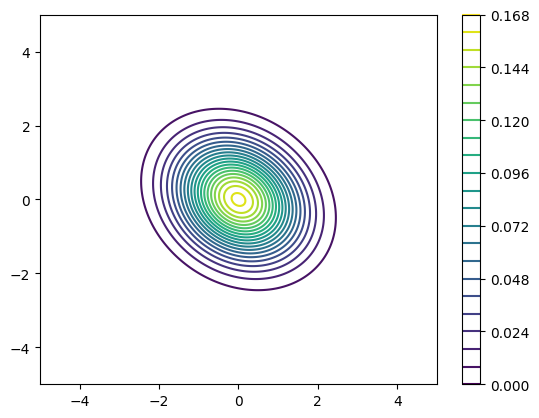

In [198]:
# Plot contour plot of the distribution
def plot_contour_dist(dist, colour=None, alpha=None, linestyle=None, x=None, y=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    plt.contour(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    # plt.show()

plot_contour_dist(prior_dist)
plt.show()

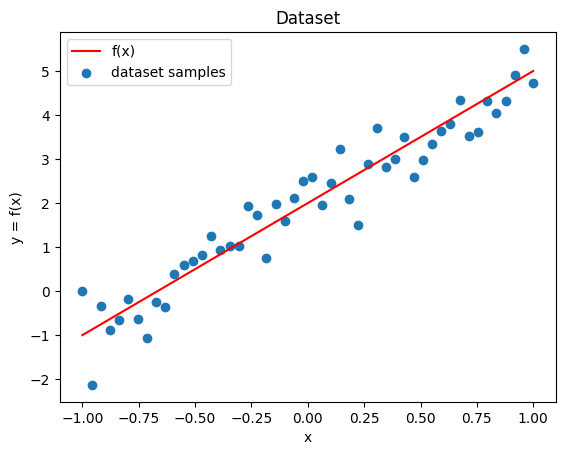

In [199]:
# dataset

sigma = 0.5

def f(x):
    return 3 * x + 2

def generate_dataset(n):
    noise = torch.distributions.Normal(0, sigma).sample((n,))
    x = torch.linspace(-1, 1, n)
    y = f(x) + noise
    return x, y

# Plot dataset
def plot_linear_dataset(x,y):
    plt.plot(x,f(x), color='red', label='f(x)')
    plt.scatter(x, y, label='dataset samples')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y = f(x)')
    plt.title('Dataset')
    plt.show()

x, y = generate_dataset(50)
plot_linear_dataset(x,y)
# plt.plot(x,f(x), color='red', label='f(x) = 3x+2')
# plt.scatter(x, y, label='dataset samples')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y = f(x)')
# plt.title('Dataset')
# plt.show()


In [200]:
# likelihood

def forward(x, theta):
    return x*theta[1] + theta[0]

def log_likelihood(theta):
    mu = forward(x, theta)
    sigma = torch.tensor(0.5)
    dist = torch.distributions.Normal(mu, sigma)
    return dist.log_prob(y).sum()

log_likelihood(torch.tensor([0.0, 3.0]))
log_likelihood(torch.tensor([2.0, 3.0]))

tensor(-36.3341)

In [201]:
# theta mle using closed form solution

import numpy as np

# Assuming X and y are your input features and target values
X = np.column_stack((np.ones_like(x), x))

# Calculate the coefficients using the closed-form solution
theta_mle = np.linalg.inv(X.T @ X) @ X.T @ np.array(y)
theta_mle

array([1.9632099, 2.9110892], dtype=float32)

In [202]:
# theta map using closed form solution

theta_map = np.linalg.inv(X.T @ X + (sigma/b)**2) @ X.T @ np.array(y)
theta_map

array([1.9393023, 2.8421798], dtype=float32)

In [221]:
X = torch.tensor(np.column_stack((np.ones_like(x), x)))
# sigma_posterior = torch.inverse((X.T @ X) / ((sigma)**2) + (1/b) * torch.inverse(torch.eye(2)))

sigma_posterior = torch.inverse((X.T @ X) / ((sigma)**2) + (1/b) * torch.inverse(torch.eye(2)))
print(sigma_posterior)
mean_posterior = sigma_posterior @ ((X.T @ np.array(y)) / ((sigma)**2) + (prior_mean/b))
print(mean_posterior)

tensor([[0.0050, 0.0000],
        [0.0000, 0.0142]])
tensor([1.9534, 2.8697])


In [222]:
X

tensor([[ 1.0000, -1.0000],
        [ 1.0000, -0.9592],
        [ 1.0000, -0.9184],
        [ 1.0000, -0.8776],
        [ 1.0000, -0.8367],
        [ 1.0000, -0.7959],
        [ 1.0000, -0.7551],
        [ 1.0000, -0.7143],
        [ 1.0000, -0.6735],
        [ 1.0000, -0.6327],
        [ 1.0000, -0.5918],
        [ 1.0000, -0.5510],
        [ 1.0000, -0.5102],
        [ 1.0000, -0.4694],
        [ 1.0000, -0.4286],
        [ 1.0000, -0.3878],
        [ 1.0000, -0.3469],
        [ 1.0000, -0.3061],
        [ 1.0000, -0.2653],
        [ 1.0000, -0.2245],
        [ 1.0000, -0.1837],
        [ 1.0000, -0.1429],
        [ 1.0000, -0.1020],
        [ 1.0000, -0.0612],
        [ 1.0000, -0.0204],
        [ 1.0000,  0.0204],
        [ 1.0000,  0.0612],
        [ 1.0000,  0.1020],
        [ 1.0000,  0.1429],
        [ 1.0000,  0.1837],
        [ 1.0000,  0.2245],
        [ 1.0000,  0.2653],
        [ 1.0000,  0.3061],
        [ 1.0000,  0.3469],
        [ 1.0000,  0.3878],
        [ 1.0000,  0

In [223]:
X.T

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000],
        [-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
         -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694, -0.4286, -0.3878,
         -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429, -0.1020, -0.0612,
         -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,  0.2245,  0.2653,
          0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,  0.5510,  0.5918,
          0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,  0.8776,  0.9184,


In [224]:
X
y

tensor([-6.0529e-04, -2.1298e+00, -3.3222e-01, -8.7421e-01, -6.5292e-01,
        -1.8189e-01, -6.4077e-01, -1.0673e+00, -2.5426e-01, -3.6687e-01,
         3.8181e-01,  5.8304e-01,  6.8395e-01,  8.1403e-01,  1.2526e+00,
         9.4022e-01,  1.0177e+00,  1.0165e+00,  1.9375e+00,  1.7206e+00,
         7.5751e-01,  1.9757e+00,  1.5946e+00,  2.1258e+00,  2.4904e+00,
         2.5981e+00,  1.9627e+00,  2.4531e+00,  3.2352e+00,  2.1031e+00,
         1.4970e+00,  2.8945e+00,  3.6949e+00,  2.8264e+00,  2.9913e+00,
         3.5049e+00,  2.5832e+00,  2.9793e+00,  3.3420e+00,  3.6277e+00,
         3.7875e+00,  4.3388e+00,  3.5169e+00,  3.6202e+00,  4.3178e+00,
         4.0505e+00,  4.3162e+00,  4.9002e+00,  5.5014e+00,  4.7262e+00])

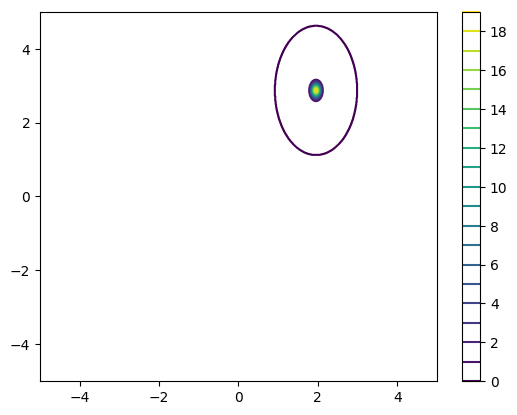

In [225]:
theta_posterior = torch.distributions.MultivariateNormal(mean_posterior, sigma_posterior)

# Plot the posterior

plot_contour_dist(theta_posterior)
plt.show()

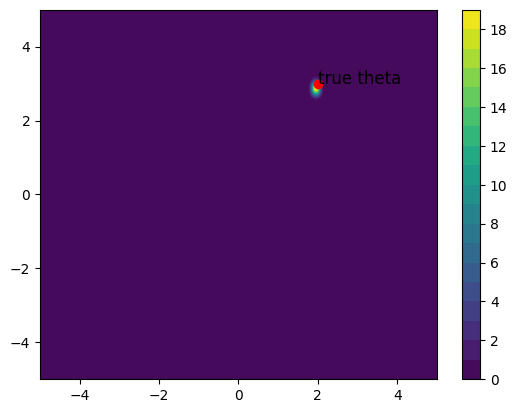

In [226]:
def plot_contourf_dist(dist, colour=None, alpha=None, linestyle=None, x=None, y=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    
    # plot a single point in red colour
    plt.plot(2, 3, 'ro', label='true theta')
    plt.text(2, 3, 'true theta', fontsize=12)
    plt.contourf(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    # plt.show()

plot_contourf_dist(theta_posterior)
plt.show()

In [227]:
x

tensor([-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
        -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694, -0.4286, -0.3878,
        -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429, -0.1020, -0.0612,
        -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,  0.2245,  0.2653,
         0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,  0.5510,  0.5918,
         0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,  0.8776,  0.9184,
         0.9592,  1.0000])

In [228]:
X

tensor([[ 1.0000, -1.0000],
        [ 1.0000, -0.9592],
        [ 1.0000, -0.9184],
        [ 1.0000, -0.8776],
        [ 1.0000, -0.8367],
        [ 1.0000, -0.7959],
        [ 1.0000, -0.7551],
        [ 1.0000, -0.7143],
        [ 1.0000, -0.6735],
        [ 1.0000, -0.6327],
        [ 1.0000, -0.5918],
        [ 1.0000, -0.5510],
        [ 1.0000, -0.5102],
        [ 1.0000, -0.4694],
        [ 1.0000, -0.4286],
        [ 1.0000, -0.3878],
        [ 1.0000, -0.3469],
        [ 1.0000, -0.3061],
        [ 1.0000, -0.2653],
        [ 1.0000, -0.2245],
        [ 1.0000, -0.1837],
        [ 1.0000, -0.1429],
        [ 1.0000, -0.1020],
        [ 1.0000, -0.0612],
        [ 1.0000, -0.0204],
        [ 1.0000,  0.0204],
        [ 1.0000,  0.0612],
        [ 1.0000,  0.1020],
        [ 1.0000,  0.1429],
        [ 1.0000,  0.1837],
        [ 1.0000,  0.2245],
        [ 1.0000,  0.2653],
        [ 1.0000,  0.3061],
        [ 1.0000,  0.3469],
        [ 1.0000,  0.3878],
        [ 1.0000,  0

In [229]:
# get the last sample from x and y
x[-1], y[-1]
x_del = x[-1]
y_del = y[-1]
X_del = torch.tensor(np.column_stack((np.ones_like(x_del), x_del)))

# y_del = np.array(y_del)
# X_del = np.array(X_del)
# y_del
y_del = torch.tensor([y_del])
# X_del = torch.tensor([X_del])
y_del
X_del

tensor([[1., 1.]])

In [230]:
sigma_posterior_del_2 = torch.inverse(torch.inverse(sigma_posterior) - (X_del.T @ X_del)/(sigma**2))
print(sigma_posterior_del_2)

tensor([[0.0051, 0.0003],
        [0.0003, 0.0151]])


In [231]:
# use solve to get the prior mean and covariance after deleting the last sample
B = torch.inverse(torch.inverse(sigma_posterior) - (X_del.T @ X_del) / ((sigma)**2))
sigma_posterior_del_1 = np.linalg.solve(np.eye(B.shape[0]),B)
sigma_posterior_del_1

array([[0.00508236, 0.00030622],
       [0.00030622, 0.01508147]])

In [232]:
torch.inverse(sigma_posterior) @ mean_posterior

tensor([392.6420, 201.9939])

In [233]:
(torch.inverse(sigma_posterior) @ mean_posterior - (X_del.T @ y_del) / ((sigma)**2))

tensor([373.7374, 183.0893])

In [234]:
sigma_posterior_del_1

array([[0.00508236, 0.00030622],
       [0.00030622, 0.01508147]])

In [235]:
mean_posterior_del = sigma_posterior_del_1 @ np.array(torch.inverse(sigma_posterior) @ mean_posterior - (X_del.T @ y_del) / ((sigma)**2))
mean_posterior_del

array([1.95553378, 2.8757029 ])

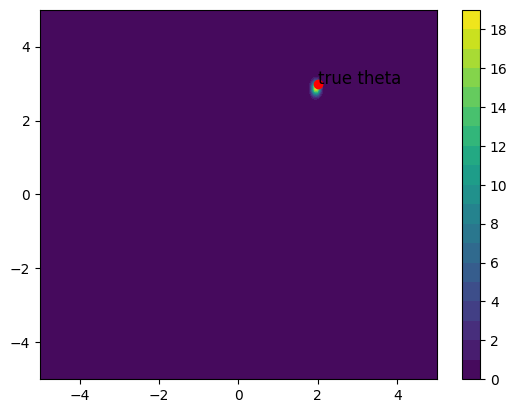

In [236]:
posterior_unlearned_1_data = torch.distributions.MultivariateNormal(torch.tensor(mean_posterior_del), torch.tensor(sigma_posterior_del_1))
plot_contourf_dist(posterior_unlearned_1_data)

In [238]:
# Deleting n samples from the dataset (from the end)

def delete_samples(n):
    x_del = x[-n:]
    y_del = y[-n:]
    X_del = torch.tensor(np.column_stack((np.ones_like(x_del), x_del)))
    if n == 1:
        y_del = torch.tensor([y_del])
    B = torch.inverse(torch.inverse(sigma_posterior) - (X_del.T @ X_del) / ((sigma)**2))
    sigma_posterior_del = np.linalg.solve(np.eye(B.shape[0]),B)
    mean_posterior_del = sigma_posterior_del @ np.array(torch.inverse(sigma_posterior) @ mean_posterior - (X_del.T @ y_del) / ((sigma)**2))
    posterior_unlearned_data = torch.distributions.MultivariateNormal(torch.tensor(mean_posterior_del), torch.tensor(sigma_posterior_del))
    plot_contourf_dist(posterior_unlearned_data)
    plt.show()

# get interactive slider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(delete_samples, n=widgets.IntSlider(min=1, max=50, step=1, value=1))


interactive(children=(IntSlider(value=1, description='n', max=50, min=1), Output()), _dom_classes=('widget-int…

<function __main__.delete_samples(n)>

posterior using closed form solution for 5 points and then for 4 points after dleeting 1 point and they should match

bayesian linear regression again

use **solve** (bishop's book code must be present)

Martin craser blr (for code)


https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-linear-regression/bayesian_linear_regression.ipynb

if ax=b given then instead of x = A-1b use x = solve(A,b)

gregory gunderson - read blog (solve & inverse)

https://gregorygundersen.com/blog/2020/12/09/matrix-inversion/

laplace torch library -> simplest nn is logistic regression and then use laplace approx to find posterior

type 2 likelihood

unnormalized posterior approx using laplace approx instead of closed form solution

precision matrix, cholesky decomposition -> use instead of inverse of covariance matrix (better conditioned)

avoid computing inverses

wolfram alpha -> use, or use monte carlo sampling


